In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/train.csv')
val = pd.read_csv('data/test.csv')
res = pd.read_csv('data/sample_submit.csv')

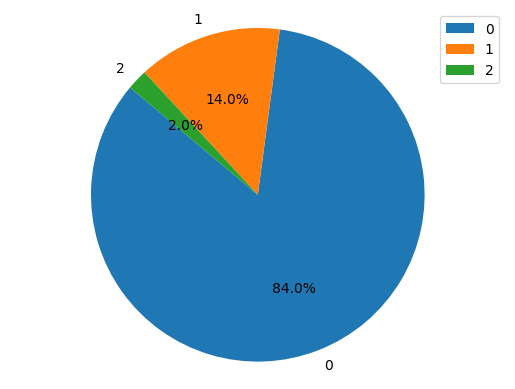

In [3]:
category_counts = df['target'].value_counts()
plt.pie(category_counts, labels={0:'正常',1:'糖尿病前期',2:'糖尿病'}, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.legend()
plt.grid(True)
plt.show()

In [4]:
bmi_mean = df[df['target']==0]['BMI'].mean()
df['BMI'] = (df['BMI'] - bmi_mean).abs()
val['BMI'] = (val['BMI'] - bmi_mean).abs()

bmi_mean = df[df['target']==0]['Education'].mean()
df['Education'] = (df['Education'] - bmi_mean).abs()
val['Education'] = (val['Education'] - bmi_mean).abs()

bmi_mean = df[df['target']==0]['Income'].mean()
df['Income'] = (df['Income'] - bmi_mean).abs()
val['Income'] = (val['Income'] - bmi_mean).abs()

In [5]:
# 创建饮食健康指数特征
df['DietHealthIndex'] = df['Fruits'] + df['Veggies']
val['DietHealthIndex'] = val['Fruits'] + val['Veggies']

# # 创建心理身体健康综合特征
# df['OverallHealth'] = df['GenHlth'] + df['MentHlth'] + df['PhysHlth']
# val['OverallHealth'] = val['GenHlth'] + val['MentHlth'] + val['PhysHlth']

# # 创建教育和收入综合特征
# df['SocioEconomicStatus'] = df['Education'] * df['Income']
# val['SocioEconomicStatus'] = val['Education'] * val['Income']

# 创建性别与年龄的交互特征
df['Sex_Age'] = df['Sex'] * df['Age']
val['Sex_Age'] = val['Sex'] * val['Age']

In [6]:
# col_list = []
# for i in df.columns:
#     if df[i].min() == 0 and df[i].max() == 1:
#         df[i] = df[i].apply(lambda x:0 if x < 0.5 else 1)
#         val[i] = val[i].apply(lambda x:0 if x < 0.5 else 1)
#     else:    
#         col_list.append(i)
# col_list.remove('target')
# col_list.remove('id')

In [7]:
X = df.drop(['id','target'],axis=1)
y = df['target']
valX = val.drop(['id'],axis=1)

selected_features_1 = ['GenHlth', 'MentHlth', 'PhysHlth']
selected_features_2 = ['Education', 'Income']

# 创建第一个多项式特征
poly = PolynomialFeatures(degree=2)
X_poly1 = poly.fit_transform(X[selected_features_1])
valX_poly1 = poly.transform(valX[selected_features_1])

# 创建第二个多项式特征
poly = PolynomialFeatures(degree=2)
X_poly2 = poly.fit_transform(X[selected_features_2])
valX_poly2 = poly.transform(valX[selected_features_2])

# 将多项式特征与原始数据合并
X_poly1_df = pd.DataFrame(X_poly1, columns=[f'poly1_{i}' for i in range(X_poly1.shape[1])])
valX_poly1_df = pd.DataFrame(valX_poly1, columns=[f'poly1_{i}' for i in range(valX_poly1.shape[1])])

X_poly2_df = pd.DataFrame(X_poly2, columns=[f'poly2_{i}' for i in range(X_poly2.shape[1])])
valX_poly2_df = pd.DataFrame(valX_poly2, columns=[f'poly2_{i}' for i in range(valX_poly2.shape[1])])

# 删除原始数据中的选择特征列
X = X.drop(selected_features_1 + selected_features_2, axis=1)
valX = valX.drop(selected_features_1 + selected_features_2, axis=1)

# 合并原始数据与多项式特征
X = pd.concat([X, X_poly1_df, X_poly2_df], axis=1)
valX = pd.concat([valX, valX_poly1_df, valX_poly2_df], axis=1)

# 使用方差筛选
variance_threshold = VarianceThreshold(threshold=0.01)
X_selected = variance_threshold.fit_transform(X)
X = pd.DataFrame(X_selected, columns=X.columns[variance_threshold.get_support()])
valX_selected = variance_threshold.transform(valX)
valX = pd.DataFrame(valX_selected, columns=valX.columns[variance_threshold.get_support()])

# 划分测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
lgb_params = {
    'n_estimators':20000,
    'objective': 'multiclass',
    'num_class': 3,
    'max_depth': 10,
    'min_child_samples': 4,
    'random_state': 42,
    'subsample': 0.8, 
    'learning_rate':0.03,
    'num_leaves': 64,
    'boosting_type': 'goss',
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    # 'device': 'gpu',
}
 
# 创建 LightGBM 数据集
sample_weights = np.ones_like(y_train)  
sample_weights[y_train == 1] = 3  
sample_weights[y_train == 2] = 2  

train_data = lgb.Dataset(X_train, label=y_train, 
                         # weight=sample_weights
                        )
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 训练模型
model = lgb.train(params=lgb_params,
                  train_set=train_data,
                  valid_sets=[val_data],
                  early_stopping_rounds=50,  
                  verbose_eval=100)  # 每隔多少轮输出日志信息

lgb_train = model.predict(X_train)
lgb_test = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8145
[LightGBM] [Info] Number of data points in the train set: 270000, number of used features: 32
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.173833
[LightGBM] [Info] Start training from score -3.912949
[LightGBM] [Info] Start training from score -1.969107
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.400048
[200]	valid_0's multi_logloss: 0.394142
[300]	valid_0's multi_logloss: 0.391017
[400]	valid_0's multi_logloss: 0.38853
[500]	valid_0's multi_logloss: 0.386585
[600]	valid_0's multi_logloss: 0.384798
[700]	valid_0's multi_logloss: 0.383115
[800]	valid_0's multi_logloss: 0.381592
[900]	valid_0's multi_logloss: 0.380449
[1000]	valid_0's multi_logloss: 

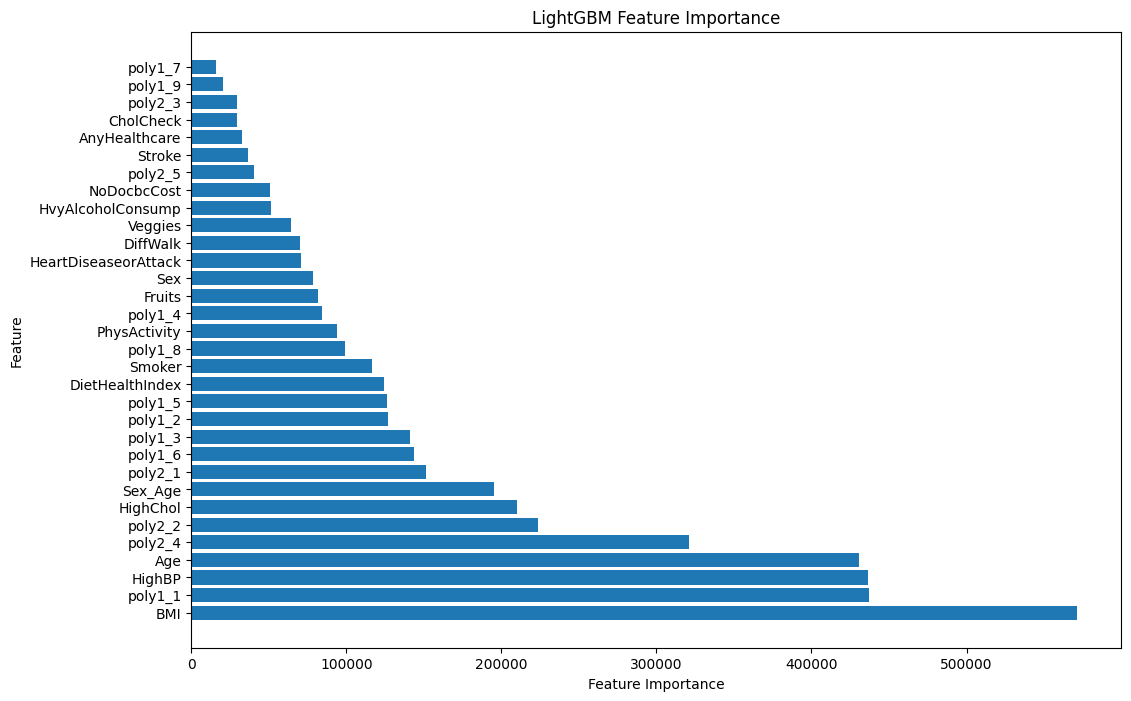

In [9]:
feature_importance = model.feature_importance(importance_type='gain')  
feature_names = model.feature_name()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.show()

In [10]:
# 真实值和预测概率
y_true = y_test.copy()
y_pred_prob = lgb_test.copy()

best_thresholds = [0.1, 0.1, 0.1]  # 初始阈值
best_f1 = 0 

for threshold_0 in tqdm(range(0, 101, 5), desc="Threshold 0"):
    for threshold_1 in range(0, 101, 5):
        for threshold_2 in range(0, 101, 5):
            thresholds = [threshold_0 / 100.0, threshold_1 / 100.0, threshold_2 / 100.0]

            y_pred = y_pred_prob.copy()
            y_pred[:, 2] = (y_pred[:, 2] >= thresholds[2]).astype(int)
            y_pred[:, 1] = (y_pred[:, 1] >= thresholds[1]).astype(int)
            y_pred[:, 0] = (y_pred[:, 0] >= thresholds[0]).astype(int)

            f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='macro')

            if f1 > best_f1:
                best_f1 = f1
                best_thresholds = thresholds

print('best_f1 is:', best_f1)
print('best_thresholds is:', best_thresholds)

Threshold 0: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.38s/it]

best_f1 is: 0.5635448259855803
best_thresholds is: [0.75, 0.1, 0.3]


In [11]:
lgb_train[:, 2] = (lgb_train[:, 2] >= best_thresholds[2]).astype(int)
lgb_train[:, 1] = (lgb_train[:, 1] >= best_thresholds[1]).astype(int)
lgb_train[:, 0] = (lgb_train[:, 0] >= best_thresholds[0]).astype(int)
lgb_test[:, 2] = (lgb_test[:, 2] >= best_thresholds[2]).astype(int)
lgb_test[:, 1] = (lgb_test[:, 1] >= best_thresholds[1]).astype(int)
lgb_test[:, 0] = (lgb_test[:, 0] >= best_thresholds[0]).astype(int)

print(f1_score(y_train, np.argmax(lgb_train, axis=1),average='macro'))
print(f1_score(y_test, np.argmax(lgb_test, axis=1),average='macro'))

0.8144411295109096
0.5635448259855803


In [12]:
y_pure = model.predict(valX)
y_pure[:, 2] = (y_pure[:, 2] >= best_thresholds[2]).astype(int)
y_pure[:, 1] = (y_pure[:, 1] >= best_thresholds[1]).astype(int)
y_pure[:, 0] = (y_pure[:, 0] >= best_thresholds[0]).astype(int)
res.target = np.argmax(y_pure, axis=1)
res.to_csv('resv7.csv')